In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.linear as frl
%matplotlib inline

### Generate Data

In [2]:
st = np.random.RandomState(89320432)
N, K1, K2 = 100_000, 10, 100

In [3]:
df0 = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df0['y'] = 3*df0['x1'] + 2*df0['x2'] + st.randn(N)
df0['lEp'] = 0.6*df0['x1'] + 0.2*df0['x2']
df0['Ep'] = np.exp(df0['lEp'])
df0['p'] = np.random.poisson(df0['Ep'])
df0['p0'] = np.where(st.rand(N) < 0.2, 0, df0['p'])
df0.head()

,id1,id2,x1,x2,y,lEp,Ep,p,p0
0,4,37,-0.259664,0.957506,0.679871,0.035703,1.036348,1,1
1,8,65,0.334285,-1.045791,-1.213136,-0.008587,0.991449,0,0
2,8,10,0.067322,-0.631068,-1.484600,-0.085820,0.917759,1,1
3,8,10,0.384297,0.485393,1.381056,0.327657,1.387713,1,0
4,6,38,-1.584996,-1.037097,-7.523866,-1.158417,0.313983,0,0


In [4]:
df = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df['y'] = 3*df['x1'] + 2*df['x2'] + 0.1*df['id1'] + 0.01*df['id2'] + st.randn(N)
df['lEp'] = 0.6*df['x1'] + 0.2*df['x2'] + 0.2*df['id1']/100 + 0.5*df['id2']/100
df['Ep'] = np.exp(df['lEp'])
df['p'] = np.random.poisson(df['Ep'])
df.head()

,id1,id2,x1,x2,y,lEp,Ep,p
0,6,73,1.523574,0.217466,5.722923,1.334637,3.798618,3
1,7,5,-0.477160,0.992419,1.810419,-0.048812,0.952360,2
2,4,46,-0.720889,0.157152,-0.820688,-0.163103,0.849504,0
3,3,38,1.738053,0.770928,8.797231,1.393017,4.026982,4
4,0,63,0.035853,-0.380131,-0.422168,0.260486,1.297560,4


### Normal OLS

In [123]:
%time smf.ols('y ~ x1 + x2', data=df).fit().params

CPU times: user 70.6 ms, sys: 36.8 ms, total: 107 ms
Wall time: 49.6 ms


/home/doug/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Intercept    0.947579
x1           3.001643
x2           1.999213
dtype: float64

In [124]:
%time frl.ols(y='y', x=['x1', 'x2'], data=df)

CPU times: user 33.7 ms, sys: 20.9 ms, total: 54.6 ms
Wall time: 10.9 ms


,coeff,stderr,low95,high95,pvalue
intercept,0.947579,0.003413,0.940890,0.954268,0.0
x1,3.001643,0.003415,2.994949,3.008336,0.0
x2,1.999213,0.003407,1.992535,2.005892,0.0


### Sparse OLS

In [11]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

CPU times: user 1.04 s, sys: 59.9 ms, total: 1.1 s
Wall time: 1.1 s


,coeff,stderr,low95,high95,pvalue
intercept,-0.009189,0.010404,-0.029580,0.011202,0.188546
x1,2.999921,0.000999,2.997962,3.001879,0.000000
x2,2.000417,0.000998,1.998461,2.002374,0.000000
id1=1,0.105988,0.004473,0.097222,0.114754,0.000000
id1=2,0.205539,0.004467,0.196783,0.214295,0.000000
...,...,...,...,...,...
id2=95,0.941612,0.014122,0.913934,0.969290,0.000000
id2=96,0.963148,0.014151,0.935412,0.990885,0.000000
id2=97,0.980529,0.014158,0.952781,1.008278,0.000000
id2=98,1.015244,0.014146,0.987518,1.042970,0.000000


In [12]:
%time _ = frl.ols(y='y', x=['x1', 'x2'], fe=[('id1', 'id2')], data=df)

CPU times: user 1.24 s, sys: 76.8 ms, total: 1.31 s
Wall time: 1.32 s


In [13]:
%time _ = frl.ols(y='y', x=['x1', 'x2'], fe=[('id1', 'id2')], data=df, drop=None, intercept=False)

CPU times: user 1.11 s, sys: 47.7 ms, total: 1.16 s
Wall time: 1.16 s


In [100]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1'], ab=['id2'], intercept=False, data=df)

CPU times: user 74.6 ms, sys: 5.98 ms, total: 80.6 ms
Wall time: 81 ms


,coeff,stderr,low95,high95,pvalue
x1,3.063206,0.003264,3.056809,3.069603,0.0
x2,2.012260,0.003385,2.005626,2.018893,0.0
id1=1,-4.165901,0.013006,-4.191393,-4.140409,0.0
id1=2,3.779030,0.013993,3.751604,3.806456,0.0
id1=3,-8.782591,0.014797,-8.811594,-8.753589,0.0
id1=4,0.566014,0.014073,0.538432,0.593596,0.0
id1=5,-4.182977,0.014393,-4.211188,-4.154767,0.0
id1=6,-5.580758,0.014630,-5.609433,-5.552083,0.0
id1=7,-1.470964,0.014767,-1.499906,-1.442021,0.0
id1=8,-1.836746,0.013664,-1.863528,-1.809965,0.0


In [6]:
import fastreg.design as des

In [8]:
des.design_matrices(y='y', x=['x1', 'x2'], absorb='id1', data=df)[1]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [-1.01852421, -0.04090869],
       [-0.0758625 ,  0.4236748 ],
       [ 1.38333201,  0.80667553]])

In [17]:
frl.ols(y='y', x=['x1', 'x2'], absorb='id1', data=df0)

,coeff,stderr,low95,high95,pvalue
x1,2.843410,0.137274,2.574358,3.112462,0.0
x2,2.074087,0.074252,1.928555,2.219618,0.0


In [18]:
frl.ols(y='y', x=['x1', 'x2'], fe=['id1'], data=df0)

,coeff,stderr,low95,high95,pvalue
intercept,1.248051,0.009990,1.228471,1.267631,0.000000
x1,3.003640,0.003167,2.997433,3.009847,0.000000
x2,2.002859,0.003147,1.996690,2.009028,0.000000
id1=1,-0.153476,0.014143,-0.181195,-0.125758,0.000000
id1=2,1.791407,0.014092,1.763787,1.819027,0.000000
id1=3,-0.993266,0.014172,-1.021041,-0.965490,0.000000
id1=4,-1.939988,0.014095,-1.967615,-1.912362,0.000000
id1=5,-3.354220,0.014165,-3.381983,-3.326457,0.000000
id1=6,6.290103,0.014188,6.262295,6.317912,0.000000
id1=7,-0.124551,0.014188,-0.152358,-0.096743,0.000000


### Poisson

In [9]:
import fastreg.general as frg

In [12]:
%time table = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, epochs=3)

Train on 1000000 samples
Epoch 1/3
4890119/1000000 [==================================================================================================================================================] - 7s 1us/sample - loss: 0.5120 - accuracy: 0.3211
Epoch 2/3
4890119/1000000 [==================================================================================================================================================] - 6s 1us/sample - loss: 0.5341 - accuracy: 0.3218
Epoch 3/3
4890119/1000000 [==================================================================================================================================================] - 6s 1us/sample - loss: 0.4827 - accuracy: 0.3218
CPU times: user 33.1 s, sys: 2.02 s, total: 35.1 s
Wall time: 32 s


In [13]:
table

,coeff,stderr,low95,high95,pvalue
intercept,0.229401,0.008529,0.212685,0.246117,0.000000
x1,0.622568,0.000784,0.621032,0.624104,0.000000
x2,0.216123,0.000784,0.214586,0.217661,0.000000
id1=1,0.000780,0.003545,-0.006169,0.007729,0.412930
id1=2,-0.012831,0.003538,-0.019766,-0.005897,0.000144
...,...,...,...,...,...
id2=95,0.286114,0.010705,0.265133,0.307095,0.000000
id2=96,0.269864,0.010791,0.248715,0.291014,0.000000
id2=97,0.290869,0.010837,0.269630,0.312108,0.000000
id2=98,0.298718,0.010764,0.277622,0.319814,0.000000


In [14]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

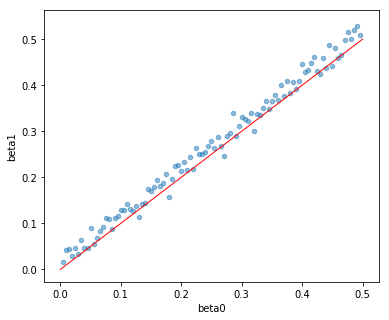

In [15]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);

### PyTorch

In [5]:
import torch

ModuleNotFoundError: No module named 'torch'

In [5]:
smf.ols('y ~ x1 + x2', data=df0).fit().params

/home/doug/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Intercept   -0.000960
x1           3.003673
x2           2.002892
dtype: float64

In [6]:
smf.poisson('p ~ x1 + x2', data=df0).fit().params

Optimization terminated successfully.
         Current function value: 1.316033
         Iterations 6


Intercept    0.004038
x1           0.598927
x2           0.202835
dtype: float64

In [26]:
frg.glm('y', ['x1', 'x2'], epochs=3, data=df0)

  0: loss = 1.4919956922531128
  1: loss = 1.0008273124694824
  2: loss = 0.9996901154518127


,coeff,stderr,low95,high95,pvalue
intercept,-0.031776,0.002211,-0.036109,-0.027443,0.0
x1,3.012812,0.002213,3.008475,3.017150,0.0
x2,1.985069,0.002201,1.980755,1.989383,0.0


In [28]:
tab, beta, sigma = frg.poisson('p', ['x1', 'x2'], epochs=3, data=df0)
tab

  0: loss = 0.755789041519165
  1: loss = 0.7324027419090271
  2: loss = 0.7327930331230164


,coeff,stderr,low95,high95,pvalue
intercept,0.005790,0.003343,-0.000761,0.012342,0.041611
x1,0.612591,0.002825,0.607054,0.618128,0.000000
x2,0.206751,0.002799,0.201266,0.212236,0.000000


In [83]:
tab, beta, sigma = frg.zero_inflated_poisson('p0', ['x1', 'x2'], epochs=5, data=df0)
tab

  0: loss = 0.7888667583465576
  1: loss = 0.7772811651229858
  2: loss = 0.7765344977378845
  3: loss = 0.7757142782211304
  4: loss = 0.7758492827415466


,coeff,stderr,low95,high95,pvalue
intercept,-0.028598,0.004929,-0.038260,-0.018937,3.284496e-09
x1,0.592937,0.003461,0.586154,0.599720,0.000000e+00
x2,0.204464,0.003433,0.197735,0.211193,0.000000e+00


In [84]:
1/(1+np.exp(-beta[-1])), np.sqrt(sigma[-1,-1])

(0.18122343307532973, 0.018943719321563707)